# Overview 

In my second project at Metis, I wanted to develop a linear regression model to predict the number of Academy Award nominations for a movie. In order to collect the data to develop my model, I had to scrape a lot of movie data from [BoxOfficeMojo.com](http://www.boxofficemojo.com/). One of the major issues with collecting the data was how slow it was to scrape the data and transform it to a format that I could use to develop the model. After doing some high-level performance profiling of my code using [`cProfile`](http://stackoverflow.com/questions/582336/how-can-you-profile-a-python-script), I discovered the major bottleneck was the http request for each movie (using the python `requests` package).

To quantify how slow it was, using my initial code (the "Base" case in the analysis below), it took ~0.3 seconds per movie for each http request. That might not sound like much, but to collect the data for the 9000+ movies from 2000-2015 on [BoxOfficeMojo.com](http://www.boxofficemojo.com/), it would take a whopping 45+ minutes!

Therefore, I set out to devleop a way to improve the performance so I could scrape movie data quicker. In the remainder of this post, I'll take you through a comparison of the performance of the different methods I tried, as well as the fastest method I settled on using. Here are the different methods I'll be comparing:

1. **Base Case** making `N` repeated HTTP requests with `requests`
2. **HTTP Sessions** (`requests.Session()`) making `N` repeated HTTP requests with the same HTTP `Session`
3. **Pooling HTTP Requests** ([`gevent.pool`](http://www.gevent.org/gevent.pool.html)) using pooling to make `N` repeated HTTP requests **\*\*my final solution**
4. **Sessions and Pooling** (`requests.Session()` and `gevent.pool`) combining methods (2) and (3)

Note: to make this code and analysis easier to follow, I'll be making all http requests to the same url and won't be performing any of the transformations that I had to do to the movie data.

## Getting Started

First, we'll import all the python packages we need.

In [1]:
# import requests so we can make http requests
import requests

# We'll use gevent for pooling requests.get() calls
import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool

# We'll use matplotlib and seaborn to plot function performance
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# ...and a few other common packages that we'll use
import time
import numpy as np
from pandas import DataFrame

To keep things simple, we'll make all our http requests to http://www.boxofficemojo.com. Hopefully they don't mind us making so many requests to their servers!

In [2]:
url = 'http://www.boxofficemojo.com/'

Let's also create an empty list, `performance_results`, to track the performance of each function

In [3]:
performance_results = []

Next, we'll create the `simulateHttpRequests` function that will allow us to simulate repeated calls (defined by `N`, aka the number of http requests) to our different http request functions we'll be creating and return the performance results for each call.

In [4]:
def simulateHttpRequests(my_func, url, method_name):
    '''
    Simulates making http requests using different functions and returns
    a dictionary with information about the function and it's performance
    '''
    times = []
    for N in np.arange(200, 1001, 200):
        secs = my_func(url, N)[1]
        times.append({'method': method_name,'N': N, 'seconds': secs})
    return times

Let's also define a reusable function, `plotPerformance`, to plot the performance comparison between the different http request methods we'll use.

In [5]:
def plotPerformance(performance_results):
    df = DataFrame(performance_results)

    g = sns.factorplot(x='N', y='seconds', hue='method', 
                   data=df, size=7, ci=None)
    
    g.set_axis_labels('N (# calls to requests)', 'Time to Complete (seconds)')
    plt.title('Performance of different url request methods vs. number of requests')

Next, we define a function `timefunc` we'll use to measure the time (in seconds) each of our functions takes to complete.

In [6]:
def timefunc(f):
    '''
    Time profiling function adapted from "Simple Timers" example at
    https://zapier.com/engineering/profiling-python-boss/
    '''
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        elapsed_time = end - start
        print f.__name__, 'took', elapsed_time, 'seconds'
        return (result, elapsed_time)
    return f_timer

## Base Case: Making `N` HTTP Requests with `requests`

The first function we'll write to make http requests is `makeRequestsBase`, our "base" or "simplest" case, where we make `N` number of calls to our `url` using `requests.get(url)`.

In [7]:
@timefunc
def makeRequestsBase(url, N):
    '''
    Function to make `N` number of requests.get calls to `url`
    '''
    for i in range(N):
        requests.get(url)

In [8]:
performance_results += simulateHttpRequests(makeRequestsBase, url, 'Base')

makeRequestsBase took 34.261341095 seconds
makeRequestsBase took 101.637778044 seconds
makeRequestsBase took 155.655081987 seconds
makeRequestsBase took 220.947253942 seconds
makeRequestsBase took 318.538731098 seconds


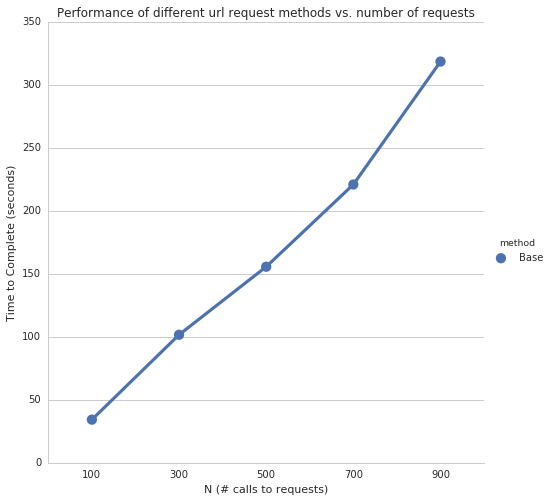

In [9]:
plotPerformance(performance_results)

As you can see, the time to complete all http requests directly increases with an increase in `N` http requests. Translation: Need to make a lot of separate `requests.get()` calls? You're going to have to wait a while. Let's see if we can do better...

## Using Sessions with `requests.Session()`

Next, since we're making repeated requests to the same url, let's see if we can use `requests.Session()` so we can reuse the underlying TCP connection and hopefully get a significant performance increase.

In [10]:
@timefunc
def makeRequestsWithSession(url, N):
    '''
    Use `requests.Session` to make `N` number of 
    `requests.Session().get` calls to `url`
    '''
    session = requests.Session()
    for i in range(N):
        session.get(url)

In [11]:
performance_results += simulateHttpRequests(makeRequestsWithSession, url, 'Sessions')

makeRequestsWithSession took 11.7829890251 seconds
makeRequestsWithSession took 43.0925910473 seconds
makeRequestsWithSession took 85.0919430256 seconds
makeRequestsWithSession took 88.1241760254 seconds
makeRequestsWithSession took 119.023229122 seconds


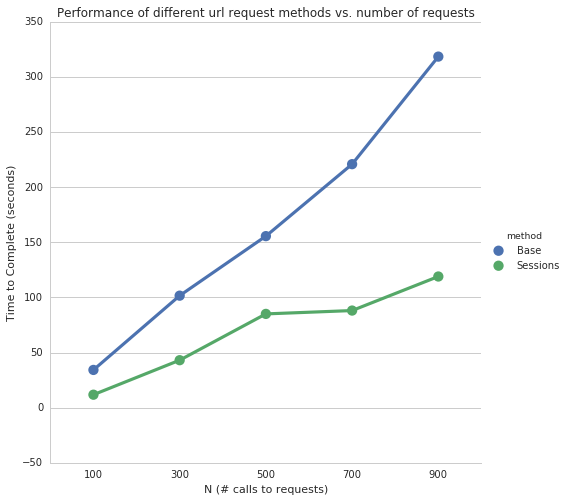

In [12]:
plotPerformance(performance_results)

Based on the results, using `requests.Sessions()` on repeated http requests improves the performance significantly. For example, using `Sessions` takes ~40% as much time as using repeated `requests.get()` (~125 seconds vs. ~325 seconds).

## Using Pooling with `gevent.pool`

It looks like using `requests.Session()` to make http requests is better than `makeRequestsBase`, but can we do even better?

In our next function, `makeRequestsWithPooling`, we make the same `requests.get` calls, except this time we wrap each of the `N` calls in a `gevent.pool`.

In [13]:
@timefunc
def makeRequestsWithPooling(url, N):
    '''
    Use `gevent.pool` library to make `N` number of requests.get 
    calls to `url` using a `pool` of `size` = `N`
    '''
    pool = Pool(25)
    for i in range(N):
        pool.spawn(requests.get, url)
    pool.join()

In [16]:
performance_results += simulateHttpRequests(makeRequestsWithPooling, url, 'Pooling')

Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/gevent/greenlet.py", line 534, in run
    result = self._run(*self.args, **self.kwargs)
  File "/opt/anaconda/lib/python2.7/site-packages/requests/api.py", line 67, in get
    return request('get', url, params=params, **kwargs)
  File "/opt/anaconda/lib/python2.7/site-packages/requests/api.py", line 53, in request
    return session.request(method=method, url=url, **kwargs)
  File "/opt/anaconda/lib/python2.7/site-packages/requests/sessions.py", line 468, in request
    resp = self.send(prep, **send_kwargs)
  File "/opt/anaconda/lib/python2.7/site-packages/requests/sessions.py", line 576, in send
    r = adapter.send(request, **kwargs)
  File "/opt/anaconda/lib/python2.7/site-packages/requests/adapters.py", line 426, in send
    raise ConnectionError(err, request=request)
ConnectionError: ('Connection aborted.', BadStatusLine("''",))
<Greenlet at 0x7f3d621cd0f0: get('http://espn.go.com/')> failed with 

makeRequestsWithPooling took 5.13833785057 seconds
makeRequestsWithPooling took 14.8546040058 seconds
makeRequestsWithPooling took 27.5836908817 seconds
makeRequestsWithPooling took 42.0458250046 seconds
makeRequestsWithPooling took 48.0854520798 seconds


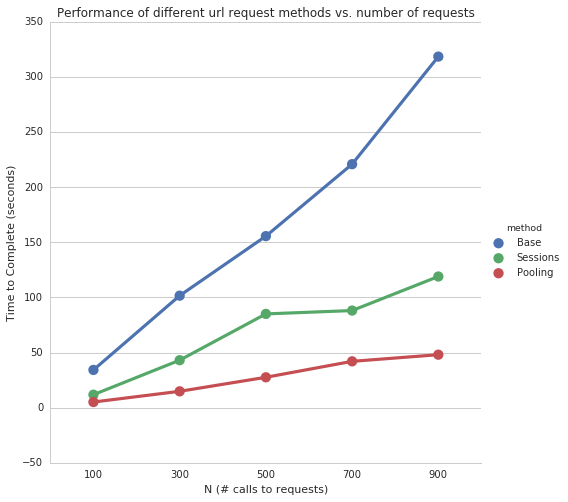

In [17]:
plotPerformance(performance_results)

Now we're talking! Using `gevent.pool` seems to significantly improve the speed with which we can make repeated http requests, without much additional cost in time as `N` increases.

## Using Sessions and Pooling

Can we do even better if we combine the `requests.Session()` and `gevent.pool` methods?

In [18]:
@timefunc
def makeRequestsWithSessionAndPooling(url, N):
    '''
    Combine `gevent.pool` and `requests.Session` techniques to make 
    `N` number of `requests` calls to `url`
    '''
    session = requests.Session()
    pool = Pool(25)
    for i in range(N):
        pool.spawn(session.get, url)
    pool.join()

In [35]:
performance_results += simulateHttpRequests(makeRequestsWithSessionAndPooling, url, 'Sessions and Pooling')

makeRequestsWithSessionAndPooling took 9.64339089394 seconds
makeRequestsWithSessionAndPooling took 11.2737030983 seconds
makeRequestsWithSessionAndPooling took 26.1544210911 seconds
makeRequestsWithSessionAndPooling took 44.1734030247 seconds
makeRequestsWithSessionAndPooling took 40.9915108681 seconds


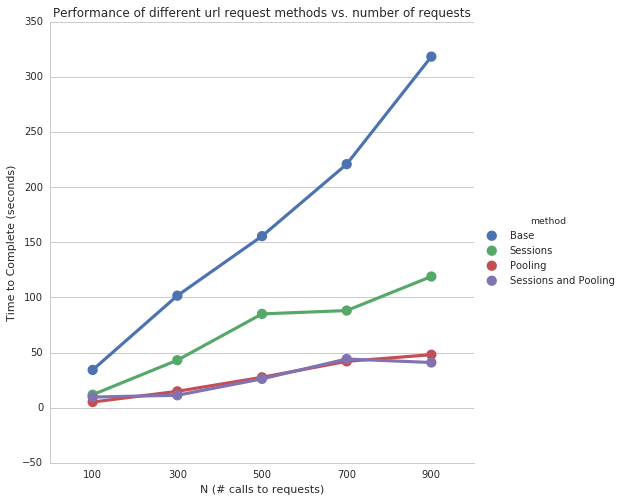

In [36]:
plotPerformance(performance_results)

Based on the simulated data, combining `requests.Session()` and `gevent.pool` doesn't improve much on simply `gevent.pool`.

## Conclusion

I ended up using the `gevent.pool` method which allowed me to scrape all 9000+ movies from [BoxOfficeMojo.com](http://www.boxofficemojo.com/) from 2000-2015 in ~10 minutes! A big improvement in the 45+ minutes it would have taken me to scrape the same amount of data with the "Base case" using repeated `requests.get()` calls.

Why didn't I use the combined `requests.Session()` and `gevent.pool` methods? Simplicity / less moving parts, especially given the combined method didn't offer much of a performance improvement.

## Potential Next Steps

This was my first experience using the [gvent](http://www.gevent.org/gevent.pool.html) package so I'd like to experiment with it in more detail and see what similar options are available. For example, I'd like to experiment to find the optimal size of the `gevent.pool`. In this post I chose a pool size of 25 based off some quick experimentation of using different values. I noticed above a value of 25, the performance increase was barely noticeable, but I'd like to explore in more detail why that might be.

Anyways, until next time and happy scraping!